In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00


# GENERAL VISUALIZER

In [ ]:
model_type = 'all'

In [ ]:
train_or_visualize = int(input("What do you want to do? (1 for Train, 2 for Visualize): "))

if train_or_visualize == 1:
    model_to_train = input("Which model do you want to train? (1-4 or 'all' or 'gans' for all models): ")
    if model_to_train =='gans':
          model_to_train = input("Which gan do you want to train? (1-4 or 'all' or 'gans' for all models): ")
    # Aquí iría el código para entrenar los modelos.
    print(f"Training model {model_to_train}...")
elif train_or_visualize == 2:
    # Aquí iría el código para visualizar los modelos.
    print("Visualizing model...")
else:
    print("Invalid option. Please choose 1 for Train or 2 for Visualize.")


KeyboardInterrupt: Interrupted by user

# IMPORT LIBRARIES

In [ ]:
import os
import nibabel as nib
import numpy as np
import torchvision
from scipy.ndimage import zoom
import numpy as np
from tqdm import tqdm
import random
from matplotlib import pyplot as plt
import re
import os
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import random
import matplotlib.pyplot as plt
import torch
from PIL import Image, ImageEnhance
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid
from torchvision.transforms import ToTensor

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

# GENERAL FUNCTIONS

In [ ]:

def resize_image(image, new_shape):
    """
    Cambia el tamaño de una imagen al nuevo shape especificado.
    """
    return resize(image, new_shape, anti_aliasing=True)

def load_and_resize_images(directory, shapes, file_type):
    """
    Carga todos los archivos .npy en el directorio especificado, los concatena y redimensiona.
    Solo carga archivos que corresponden al tipo especificado ('images' o 'labels').
    """
    original_images = []
    resized_images_128 = []

    # Cargar los archivos .npy y concatenarlos
    for i in range(6):  # Para los archivos ordenados de 0 a 3
        file_name = f"{file_type}_batch_{i}.npy"
        file_path = os.path.join(directory, file_name)
        if os.path.exists(file_path):
            batch = np.load(file_path)

            # Aplanar las imágenes de cada batch y agregarlas a las listas
            for image in tqdm(batch):
                original_images.append(image)
                resized_images_128.append(resize_image(image, shapes[0]))

    return np.array(original_images), np.array(resized_images_128)

In [ ]:
def prepare_dataloaders(images, images_128, batch_size=64, test_size=0.2, validation_size=0.5):
    """
    Prepara dataloaders para entrenamiento, prueba y validación.

    Args:
    images (numpy array): Imágenes de alta resolución.
    images_128 (numpy array): Imágenes de baja resolución.
    batch_size (int): Tamaño del batch.
    test_size (float): Porcentaje del dataset para el conjunto de prueba.
    validation_size (float): Porcentaje del conjunto de prueba para la validación.
    """
    # Convertir a tensores y normalizar
    images_tensor = torch.tensor(images).float() / 255.0
    images_128_tensor = torch.tensor(images_128).float() / 255.0

    # Cambiar de forma para que sean compatibles con el modelo (B, C, H, W)
    images_tensor = images_tensor.unsqueeze(1)
    images_128_tensor = images_128_tensor.unsqueeze(1)

    # Dividir en conjuntos de entrenamiento y prueba
    train_x, test_x, train_y, test_y = train_test_split(images_128_tensor, images_tensor, test_size=test_size, random_state=42)

    # Dividir el conjunto de prueba en prueba y validación
    test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=validation_size, random_state=42)

    # Crear datasets
    train_dataset = TensorDataset(train_x, train_y)
    test_dataset = TensorDataset(test_x, test_y)
    val_dataset = TensorDataset(val_x, val_y)

    # Crear dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, val_loader



In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, scheduler=None, early_stopping_patience=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_path = 'best_model.pth'  # Define la ruta para guardar el mejor modelo

    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0
        for low_res, high_res in train_loader:
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            optimizer.zero_grad()
            outputs = model(low_res)
            loss = criterion(outputs, high_res)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)

        # Validación
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for low_res, high_res in val_loader:
                low_res = low_res.to(device)
                high_res = high_res.to(device)

                outputs = model(low_res)
                loss = criterion(outputs, high_res)
                running_val_loss += loss.item()
        avg_val_loss = running_val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

        # Actualizar el programador de tasa de aprendizaje
        if scheduler:
            scheduler.step(avg_val_loss)

        # Checkpoint para el mejor modelo
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), best_model_path)  # Guarda el estado del modelo
            print(f"Mejor modelo guardado con pérdida de validación: {best_val_loss}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == early_stopping_patience:
                print("Detención temprana!")
                break

    # Cargar el mejor modelo después del entrenamiento
    model.load_state_dict(torch.load(best_model_path))
    return model


In [ ]:
def adjust_contrast(image):
    """Ajusta el contraste de una imagen mediante el ecualizado del histograma."""
    # Ecualizar el histograma de la imagen
    adjusted_img = exposure.equalize_adapthist(image, clip_limit=0.03)
    return adjusted_img
def test_model_and_plot_random(model, test_loader, device):
    """
    Evalúa el modelo en el conjunto de prueba, calcula las métricas SSIM y PSNR y muestra
    un plot aleatorio con la imagen original, la imagen de baja resolución y la predicha.
    """
    model.eval()
    ssim_total = 0
    psnr_total = 0
    num_samples = 0

    random_image_selected = False
    random_index = random.randint(0, len(test_loader.dataset) - 1)

    with torch.no_grad():
        for i, (low_res, high_res) in enumerate(test_loader):
            low_res = low_res.to(device)
            high_res = high_res.to(device)

            outputs = model(low_res)

            for j in range(outputs.size(0)):
                predicted = outputs[j].squeeze().cpu().numpy()
                original = high_res[j].squeeze().cpu().numpy()
                low_res_img = low_res[j].squeeze().cpu().numpy()

                ssim_total += ssim(original, predicted, data_range=predicted.max() - predicted.min())
                psnr_total += psnr(original, predicted, data_range=predicted.max() - predicted.min())

                if i * test_loader.batch_size + j == random_index:
                    plt.figure(figsize=(12, 4))

                    plt.subplot(1, 3, 1)
                    plt.imshow(low_res_img, cmap='gray')
                    plt.title("Low Resolution")
                    plt.axis('off')

                    plt.subplot(1, 3, 2)
                    plt.imshow(predicted, cmap='gray')
                    plt.title("Predicted")
                    plt.axis('off')

                    plt.subplot(1, 3, 3)
                    plt.imshow(original, cmap='gray')
                    plt.title("Ground Truth")
                    plt.axis('off')

                    plt.show()

                    random_image_selected = True

            num_samples += outputs.size(0)
            if random_image_selected:
                break

    avg_ssim = ssim_total / num_samples
    avg_psnr = psnr_total / num_samples

    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

#  MODELS

## EDSR

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, num_filters):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_filters)  # Batch Normalization after Conv1
        self.conv2 = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_filters)  # Batch Normalization after Conv2

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x + residual
        return x

class Upsampling(nn.Module):
    def __init__(self, num_filters, scale_factor):
        super(Upsampling, self).__init__()
        self.conv = nn.Conv2d(num_filters, num_filters * (scale_factor ** 2), kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters * (scale_factor ** 2))  # Batch Normalization
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        x = self.bn(self.conv(x))
        x = self.pixel_shuffle(x)
        return x

class EDSRModel(nn.Module):
    def __init__(self, num_filters, num_of_residual_blocks, scale_factor):
        super(EDSRModel, self).__init__()
        self.first_conv = nn.Conv2d(1, num_filters, kernel_size=3, padding=1)
        self.res_blocks = nn.Sequential(
            *[ResBlock(num_filters) for _ in range(num_of_residual_blocks)]
        )
        self.second_conv = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(num_filters)  # Batch Normalization
        self.upsampling = Upsampling(num_filters, scale_factor)
        self.final_conv = nn.Conv2d(num_filters, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.first_conv(x)
        residual = x
        x = self.res_blocks(x)
        x = self.bn(self.second_conv(x))
        x = x + residual
        x = self.upsampling(x)
        x = self.final_conv(x)
        return x

## MODIFIED SRCNN

In [ ]:
class ModifiedSRCNN(nn.Module):
    def __init__(self, scale_factor=2):
        super(ModifiedSRCNN, self).__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bicubic')
        self.conv1 = nn.Conv2d(64, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Capa convolucional inicial
        initial_features = self.relu(self.initial_conv(x))

        # Combinar las características iniciales con la imagen de entrada
        combined_features = initial_features + x

        # Upsampling y procesamiento adicional
        upsampled = self.upsample(combined_features)
        x1 = self.relu(self.conv1(upsampled))
        x2 = self.relu(self.conv2(x1))
        x3 = self.conv3(x2)
        return x3

## ResNet

In [ ]:
class ResidualBlockDense(nn.Module):
    def __init__(self):
        super(ResidualBlockDense, self).__init__()
        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # Cambiado de 1 a 64 en los canales de entrada
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)  # Cambiado de 1 a 64 en los canales de salida
        self.bn2 = nn.BatchNorm2d(64)  # Cambiado de 1 a 64 en BatchNorm

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class SRResNetDense(nn.Module):
    def __init__(self):
        super(SRResNetDense, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.residual_blocks = self.make_layers(ResidualBlockDense, 4)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)  # Cambiado de 1 a 64 en los canales de entrada
        self.bn = nn.BatchNorm2d(64)
        self.upsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(64, 256, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )
        self.conv3 = nn.Conv2d(64, 1, kernel_size=9, padding=4)

    def make_layers(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        residual = out
        out = self.residual_blocks(out)
        out = self.bn(self.conv2(out))
        out += residual
        out = self.upsample(out)
        out = self.conv3(out)
        return out

## SIMPLE SRCNN

In [ ]:
class SRCNN(nn.Module):
    def __init__(self, scale_factor=2):
        super(SRCNN, self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bicubic')
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.upsample(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

## SRCNNSE

In [ ]:

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Updated SRCNN model with attention
class SRCNNSE (nn.Module):
    def __init__(self):
        super(SRCNNSE, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic')
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.se1 = SEBlock(64)  # Attention after first conv layer
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bicubic')
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.se2 = SEBlock(32)  # Attention after second conv layer
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.se1(x)  # Apply attention
        x = self.relu(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.se2(x)  # Apply attention
        x = self.relu(x)
        x = self.conv3(x)
        return x


## RCAN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(self, rgb_range, rgb_mean, rgb_std, sign=-1):
        super(MeanShift, self).__init__(1, 1, kernel_size=1)
        std = torch.tensor(rgb_std)
        self.weight.data = torch.eye(1).view(1, 1, 1, 1)
        self.weight.data.div_(std)
        self.bias.data = sign * rgb_range * torch.tensor(rgb_mean)
        self.bias.data.div_(std)
        self.requires_grad = False

class BasicBlock(nn.Sequential):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride=1, bias=False,
        bn=True, act=nn.ReLU(True)):

        m = [nn.Conv2d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size//2), stride=stride, bias=bias)
        ]
        if bn: m.append(nn.BatchNorm2d(out_channels))
        if act is not None: m.append(act)
        super(BasicBlock, self).__init__(*m)

class ResBlockCAN(nn.Module):
    def __init__(
        self, conv, n_feat, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlockCAN, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if i == 0: m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class Upsampler(nn.Sequential):
    def __init__(self, conv, scale, n_feat, bn=False, act=False, bias=True):

        m = []
        if (scale & (scale - 1)) == 0:
            for _ in range(int(math.log(scale, 2))):
                m.append(conv(n_feat, 4 * n_feat, 3, bias))
                m.append(nn.PixelShuffle(2))
                if bn: m.append(nn.BatchNorm2d(n_feat))
                if act: m.append(act())
        elif scale == 3:
            m.append(conv(n_feat, 9 * n_feat, 3, bias))
            m.append(nn.PixelShuffle(3))
            if bn: m.append(nn.BatchNorm2d(n_feat))
            if act: m.append(act())
        else:
            raise NotImplementedError

        super(Upsampler, self).__init__(*m)
# Channel Attention (CA) Layer
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y

# Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1):
        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn:
                modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0:
                modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

# Residual Group (RG)
class ResidualGroup(nn.Module):
    def __init__(self, conv, n_feat, kernel_size, reduction, act, res_scale, n_resblocks):
        super(ResidualGroup, self).__init__()
        modules_body = [RCAB(conv, n_feat, kernel_size, reduction, bias=True, bn=False, act=nn.ReLU(True), res_scale=1) for _ in range(n_resblocks)]
        modules_body.append(conv(n_feat, n_feat, kernel_size))
        self.body = nn.Sequential(*modules_body)

    def forward(self, x):
        res = self.body(x)
        res += x
        return res

class RCAN(nn.Module):
    def __init__(self, conv=default_conv):
        super(RCAN, self).__init__()

        # Definir valores predeterminados
        n_resgroups = 8
        n_resblocks = 8
        n_feats = 64
        kernel_size = 3
        reduction = 4    # Por ejemplo, 16
        scale = 4         # Para cambiar de (1, 64, 64) a (1, 256, 256)
        n_colors = 1
        res_scale = 1

        act = nn.ReLU(True)

        # Eliminar RGB mean y std para escala de grises
        self.sub_mean = MeanShift(255, (0.0,), (1.0,))  # Asumiendo un rango RGB de 255

        # Definir módulo de cabeza
        modules_head = [conv(n_colors, n_feats, kernel_size)]

        # Definir módulo de cuerpo
        modules_body = [
            ResidualGroup(
                conv, n_feats, kernel_size, reduction, act=act, res_scale=res_scale, n_resblocks=n_resblocks) \
            for _ in range(n_resgroups)]
        modules_body.append(conv(n_feats, n_feats, kernel_size))

        # Definir módulo de cola
        modules_tail = [
            Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)]

        self.add_mean = MeanShift(255, (0.0,), (1.0,), 1)

        self.head = nn.Sequential(*modules_head)
        self.body = nn.Sequential(*modules_body)
        self.tail = nn.Sequential(*modules_tail)

    def forward(self, x):
        x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x



## SWINIR

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=1, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=1, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=1,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)

        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops


## mhmM-AT


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def edge_detection_filter():
    return torch.tensor([[[[-1., -1., -1.],
                           [-1.,  8., -1.],
                           [-1., -1., -1.]]]], dtype=torch.float32)

def contrast_increase_filter():
    return torch.tensor([[[[0., -1., 0.],
                           [-1., 5., -1.],
                           [0., -1., 0.]]]], dtype=torch.float32)

class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, heads):
        super(MultiHeadAttention, self).__init__()
        self.heads = heads
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels // 2, in_channels, kernel_size=3, padding=1),
                nn.Sigmoid()
            ) for _ in range(heads)
        ])

    def forward(self, x):
        attention_maps = [head(x) for head in self.attention_heads]
        attention = torch.mean(torch.stack(attention_maps), dim=0)
        return x * attention

class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super(SuperResolutionNetwork, self).__init__()
        self.edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.contrast_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.features = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.attention = MultiHeadAttention(in_channels=64, heads=4)
        self.upscale = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 256x256
            nn.ReLU()
        )
        self.output = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.edge_filter.weight = nn.Parameter(edge_detection_filter(), requires_grad=False)
        self.contrast_filter.weight = nn.Parameter(contrast_increase_filter(), requires_grad=False)

    def forward(self, x):
        edge_detected = self.edge_filter(x)
        contrast_increased = self.contrast_filter(x)
        concatenated = torch.cat((edge_detected, contrast_increased, x), 1)
        features = self.features(concatenated)
        attention_applied = self.attention(features)
        upscaled = self.upscale(attention_applied)
        out = self.output(upscaled)
        return out

model = SuperResolutionNetwork()
input_image = torch.rand(1, 1, 64, 64)  # Imagen de entrada de 64x64
output = model(input_image)

print("Tamaño de la salida:", output.size())


Tamaño de la salida: torch.Size([1, 1, 256, 256])


#texture super resolution

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariedKernelSizeAttentionHead(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(VariedKernelSizeAttentionHead, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return self.sigmoid(x)
class MultiModalMultiHeadAttention(nn.Module):
    def __init__(self, in_channels, heads, kernel_sizes):
        super(MultiModalMultiHeadAttention, self).__init__()
        self.heads = heads
        self.kernel_sizes = kernel_sizes
        self.in_channels = in_channels
        self.out_channels = in_channels  # Asegurar que los canales de salida coincidan con los de entrada
        self.attention_heads = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=ks, padding=ks // 2),
                nn.ReLU(),
                nn.Conv2d(in_channels // 2, self.out_channels, kernel_size=ks, padding=ks // 2),
                nn.Sigmoid()
            ) for ks in kernel_sizes for _ in range(heads // len(kernel_sizes))
        ])

    def forward(self, x):
        attention_maps = [head(x) for head in self.attention_heads]
        attention = torch.mean(torch.stack(attention_maps, dim=0), dim=0)
        return x * attention

# Ejemplo de cómo integrar en la SuperResolutionNetwork
class SuperResolutionNetworkExtended(nn.Module):
    def __init__(self):
        super(SuperResolutionNetworkExtended, self).__init__()
        self.edge_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.contrast_filter = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.features = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.attention = MultiModalMultiHeadAttention(in_channels=64, heads=4, kernel_sizes=[3, 5, 7])
        self.upscale = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )
        self.output = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.edge_filter.weight = nn.Parameter(edge_detection_filter(), requires_grad=False)
        self.contrast_filter.weight = nn.Parameter(contrast_increase_filter(), requires_grad=False)

    def forward(self, x):
        edge_detected = self.edge_filter(x)
        contrast_increased = self.contrast_filter(x)
        concatenated = torch.cat((edge_detected, contrast_increased, x), 1)
        features = self.features(concatenated)
        attention_applied = self.attention(features)
        upscaled = self.upscale(attention_applied)
        out = self.output(upscaled)
        return out

# Asegúrate de ajustar las dimensiones de entrada y salida según tus necesidades específicas.


model = SuperResolutionNetworkExtended()
input_image = torch.rand(1, 1, 64, 64)  # Imagen de entrada de 64x64
output = model(input_image)

print("Tamaño de la salida:", output.size())

Tamaño de la salida: torch.Size([1, 1, 256, 256])


## GAN

### GENERATOR

In [ ]:

class Generator(nn.Module):
    """
    The generator in the SRGAN, as defined in the paper. Architecture identical to the SRResNet.
    """

    def __init__(self,model, large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=4):
        """
        :param large_kernel_size: kernel size of the first and last convolutions which transform the inputs and outputs
        :param small_kernel_size: kernel size of all convolutions in-between, i.e. those in the residual and subpixel convolutional blocks
        :param n_channels: number of channels in-between, i.e. the input and output channels for the residual and subpixel convolutional blocks
        :param n_blocks: number of residual blocks
        :param scaling_factor: factor to scale input images by (along both dimensions) in the subpixel convolutional block
        """
        super(Generator, self).__init__()
        # The generator is simply an SRResNet, as above
        self.net = model

    def initialize_with_srresnet(self, srresnet_checkpoint):
        """
        Initialize with weights from a trained SRResNet.

        :param srresnet_checkpoint: checkpoint filepath
        """
        srresnet = torch.load(srresnet_checkpoint)['model']
        self.net.load_state_dict(srresnet.state_dict())

        print("\nLoaded weights from pre-trained SRResNet.\n")

    def forward(self, lr_imgs):
        """
        Forward prop.

        :param lr_imgs: low-resolution input images, a tensor of size (N, 3, w, h)
        :return: super-resolution output images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        """
        sr_imgs = self.net(lr_imgs)  # (N, n_channels, w * scaling factor, h * scaling factor)

        return sr_imgs




### DISCRIMINATOR

In [ ]:
class ConvolutionalBlock(nn.Module):
    """
    A convolutional block as a part of the discriminator in a SRGAN.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, batch_norm, activation):
        """
        Initialize the ConvolutionalBlock.
        """
        super(ConvolutionalBlock, self).__init__()
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, kernel_size//2)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if activation == 'LeakyReLU':
            layers.append(nn.LeakyReLU(0.2))
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_block(x)

class Discriminator(nn.Module):
    """
    The discriminator in the SRGAN, as defined in the paper.
    """

    def __init__(self, kernel_size=3, n_channels=64, n_blocks=8, fc_size=1024):
        """
        :param kernel_size: kernel size in all convolutional blocks
        :param n_channels: number of output channels in the first convolutional block, after which it is doubled in every 2nd block thereafter
        :param n_blocks: number of convolutional blocks
        :param fc_size: size of the first fully connected layer
        """
        super(Discriminator, self).__init__()

        in_channels = 1

        # A series of convolutional blocks
        # The first, third, fifth (and so on) convolutional blocks increase the number of channels but retain image size
        # The second, fourth, sixth (and so on) convolutional blocks retain the same number of channels but halve image size
        # The first convolutional block is unique because it does not employ batch normalization
        conv_blocks = list()
        for i in range(n_blocks):
            out_channels = (n_channels if i is 0 else in_channels * 2) if i % 2 is 0 else in_channels
            conv_blocks.append(
                ConvolutionalBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   stride=1 if i % 2 is 0 else 2, batch_norm=i is not 0, activation='LeakyReLu'))
            in_channels = out_channels
        self.conv_blocks = nn.Sequential(*conv_blocks)

        # An adaptive pool layer that resizes it to a standard size
        # For the default input size of 96 and 8 convolutional blocks, this will have no effect
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))

        self.fc1 = nn.Linear(out_channels * 6 * 6, fc_size)

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.fc2 = nn.Linear(1024, 1)

        # Don't need a sigmoid layer because the sigmoid operation is performed by PyTorch's nn.BCEWithLogitsLoss()

    def forward(self, imgs):
        """
        Forward propagation.

        :param imgs: high-resolution or super-resolution images which must be classified as such, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        :return: a score (logit) for whether it is a high-resolution image, a tensor of size (N)
        """
        batch_size = imgs.size(0)
        output = self.conv_blocks(imgs)
        output = self.adaptive_pool(output)
        output = self.fc1(output.view(batch_size, -1))
        output = self.leaky_relu(output)
        logit = self.fc2(output)

        return logit

### TRAIN FUNCTION

In [ ]:
def train_gan(generator, discriminator, truncated_vgg19, content_loss_criterion, adversarial_loss_criterion, train_loader, num_epochs, optimizer_g, optimizer_d, device):
    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        for i, (lr_imgs, hr_imgs) in enumerate(train_loader):

            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            # Actualización del Discriminador
            optimizer_d.zero_grad()

            # Trabajar con imágenes reales
            real_labels = torch.ones(hr_imgs.size(0), 1).to(device)
            real_output = discriminator(hr_imgs)
            loss_real = adversarial_loss_criterion(real_output, real_labels)

            # Trabajar con imágenes falsas generadas
            fake_imgs = generator(lr_imgs)
            fake_labels = torch.zeros(hr_imgs.size(0), 1).to(device)
            fake_output = discriminator(fake_imgs.detach())
            loss_fake = adversarial_loss_criterion(fake_output, fake_labels)

            # Pérdida y actualización del discriminador
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()

            # Actualización del Generador
            optimizer_g.zero_grad()

            # Generar imágenes falsas
            fake_imgs = generator(lr_imgs)

            # Calcular pérdida perceptual (contenido + adversarial)
            fake_output = discriminator(fake_imgs)
            adversarial_loss = adversarial_loss_criterion(fake_output, real_labels)
            fake_imgs_vgg = truncated_vgg19(fake_imgs)
            hr_imgs_vgg = truncated_vgg19(hr_imgs).detach()
            content_loss = content_loss_criterion(fake_imgs_vgg, hr_imgs_vgg)
            perceptual_loss = content_loss + 0.001 * adversarial_loss

            # Retropropagación y actualización del generador
            perceptual_loss.backward()
            optimizer_g.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss D: {loss_d.item()}, Loss G: {perceptual_loss.item()}')

    return generator, discriminator



In [ ]:
class TruncatedVGG19(nn.Module):
    """
    A truncated VGG19 network, such that its output is the 'feature map obtained by the j-th convolution (after activation)
    before the i-th maxpooling layer within the VGG19 network', as defined in the paper.

    Used to calculate the MSE loss in this VGG feature-space, i.e. the VGG loss.
    """

    def __init__(self, i, j):
        """
        :param i: the index i in the definition above
        :param j: the index j in the definition above
        """
        super(TruncatedVGG19, self).__init__()

        # Load the pre-trained VGG19 available in torchvision
        vgg19 = torchvision.models.vgg19(pretrained=True)
        vgg19.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        maxpool_counter = 0
        conv_counter = 0
        truncate_at = 0
        # Iterate through the convolutional section ("features") of the VGG19
        for layer in vgg19.features.children():
            truncate_at += 1

            # Count the number of maxpool layers and the convolutional layers after each maxpool
            if isinstance(layer, nn.Conv2d):
                conv_counter += 1
            if isinstance(layer, nn.MaxPool2d):
                maxpool_counter += 1
                conv_counter = 0

            # Break if we reach the jth convolution after the (i - 1)th maxpool
            if maxpool_counter == i - 1 and conv_counter == j:
                break

        # Check if conditions were satisfied
        assert maxpool_counter == i - 1 and conv_counter == j, "One or both of i=%d and j=%d are not valid choices for the VGG19!" % (
            i, j)

        # Truncate to the jth convolution (+ activation) before the ith maxpool layer
        self.truncated_vgg19 = nn.Sequential(*list(vgg19.features.children())[:truncate_at + 1])

    def forward(self, input):
        """
        Forward propagation
        :param input: high-resolution or super-resolution images, a tensor of size (N, 3, w * scaling factor, h * scaling factor)
        :return: the specified VGG19 feature map, a tensor of size (N, feature_map_channels, feature_map_w, feature_map_h)
        """
        output = self.truncated_vgg19(input)  # (N, feature_map_channels, feature_map_w, feature_map_h)

        return output

 # DATA LOAD


In [ ]:
# Usamos la función para cargar y redimensionar las imágenes
path = '/content/drive/MyDrive/TFM'  # El directorio con los archivos .npy
shapes = [(64, 64)]
images, images_128,= load_and_resize_images(path, shapes,'images')
# labels, labels_128 = load_and_resize_images(path, shapes,'labels')
# Preparar el dataloader
# labels=labels.round()


  0%|          | 0/2866 [00:00<?, ?it/s]

  0%|          | 0/2183 [00:00<?, ?it/s]

  0%|          | 0/2516 [00:00<?, ?it/s]

  0%|          | 0/2683 [00:00<?, ?it/s]

  0%|          | 0/1864 [00:00<?, ?it/s]

  0%|          | 0/2271 [00:00<?, ?it/s]

In [ ]:
print("preparing dataloader....")
# Ejemplo de uso
train_loader, test_loader, val_loader = prepare_dataloaders(images, images_128, batch_size=64)
print(" dataloader created")

preparing dataloader....
 dataloader created


# TRAINERS

Epoch [1/50], Train Loss: 0.24847988450589278, Val Loss: 0.17262427715791595
Mejor modelo guardado con pérdida de validación: 0.17262427715791595
Epoch [2/50], Train Loss: 0.16897367186223466, Val Loss: 0.16549670555525356
Mejor modelo guardado con pérdida de validación: 0.16549670555525356
Epoch [3/50], Train Loss: 0.16385228318265743, Val Loss: 0.16108334652251668
Mejor modelo guardado con pérdida de validación: 0.16108334652251668
Epoch [4/50], Train Loss: 0.1614567972202268, Val Loss: 0.16159961852762433
Epoch [5/50], Train Loss: 0.16058829644074044, Val Loss: 0.15720863143603006
Mejor modelo guardado con pérdida de validación: 0.15720863143603006
Epoch [6/50], Train Loss: 0.1580994833467735, Val Loss: 0.15712517210178906
Mejor modelo guardado con pérdida de validación: 0.15712517210178906
Epoch [7/50], Train Loss: 0.157572871995055, Val Loss: 0.15566748819417423
Mejor modelo guardado con pérdida de validación: 0.15566748819417423
Epoch [8/50], Train Loss: 0.1563510206217567, Val L

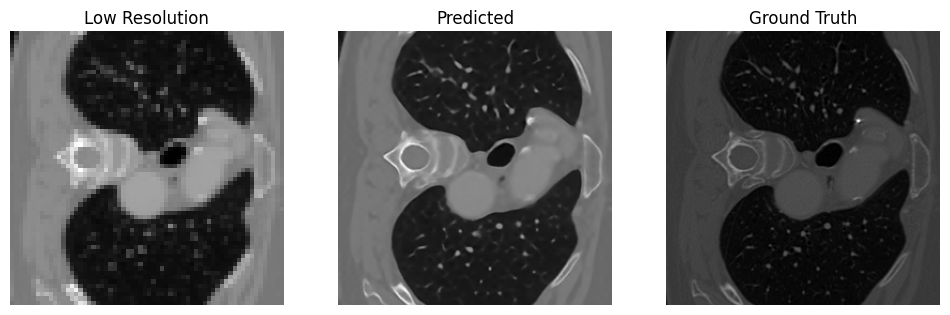

Average SSIM: 0.7335
Average PSNR: 30.2894


In [ ]:
model_SRCNN = SuperResolutionNetworkExtended()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_SRCNN.parameters(), lr=0.001)

# Entrenar el modelo
model_SRCNN=train_model(model_SRCNN, train_loader, val_loader, criterion, optimizer, epochs=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_and_plot_random(model_SRCNN, test_loader, device)
torch.save(model_SRCNN, 'model_SRCNN.pth')

## SRFILTERSNETWORK

Epoch [1/30], Train Loss: 0.2540990258256594, Val Loss: 0.17165655179156197
Mejor modelo guardado con pérdida de validación: 0.17165655179156197
Epoch [2/30], Train Loss: 0.1683024481870234, Val Loss: 0.1633444397813744
Mejor modelo guardado con pérdida de validación: 0.1633444397813744
Epoch [3/30], Train Loss: 0.16319685659060876, Val Loss: 0.15966462832358147
Mejor modelo guardado con pérdida de validación: 0.15966462832358147
Epoch [4/30], Train Loss: 0.1604049575722052, Val Loss: 0.15854532536533145
Mejor modelo guardado con pérdida de validación: 0.15854532536533145
Epoch [5/30], Train Loss: 0.1588457666958372, Val Loss: 0.15623217531376415
Mejor modelo guardado con pérdida de validación: 0.15623217531376415
Epoch [6/30], Train Loss: 0.15727945254701708, Val Loss: 0.15613068060742485
Mejor modelo guardado con pérdida de validación: 0.15613068060742485
Epoch [7/30], Train Loss: 0.15652831761787336, Val Loss: 0.15428382754325867
Mejor modelo guardado con pérdida de validación: 0.15

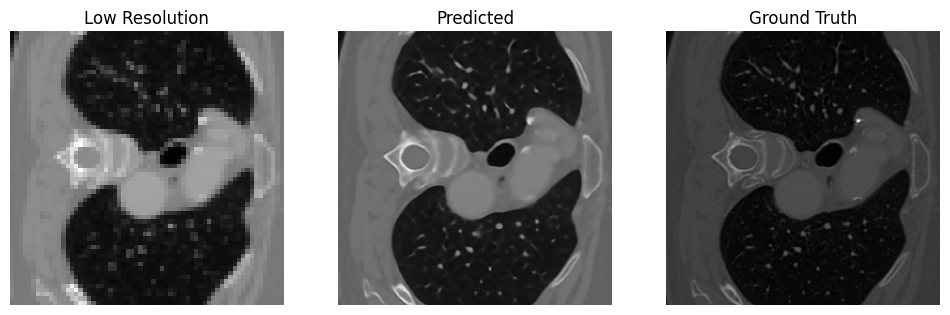

Average SSIM: 0.7320
Average PSNR: 30.2292


In [ ]:
SuperResolutionNetwork()
scale_factor = 4
model_SRCNN = SuperResolutionNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_SRCNN.parameters(), lr=0.001)




Epoch [1/50], Train Loss: 0.14931352948769927, Val Loss: 0.14812397584319115
Mejor modelo guardado con pérdida de validación: 0.14812397584319115
Epoch [2/50], Train Loss: 0.14925066624871558, Val Loss: 0.14820331898000505
Epoch [3/50], Train Loss: 0.14894785496095816, Val Loss: 0.14854850504133438
Epoch [4/50], Train Loss: 0.14908671155571937, Val Loss: 0.14799406536751322
Mejor modelo guardado con pérdida de validación: 0.14799406536751322
Epoch [5/50], Train Loss: 0.14898500753980543, Val Loss: 0.14851069806350603
Epoch [6/50], Train Loss: 0.14858394166868594, Val Loss: 0.14782679751515387
Mejor modelo guardado con pérdida de validación: 0.14782679751515387
Epoch [7/50], Train Loss: 0.14853037137848635, Val Loss: 0.14879008407394093
Epoch [8/50], Train Loss: 0.14859644452937776, Val Loss: 0.14807208172149128
Epoch [9/50], Train Loss: 0.14847553606248565, Val Loss: 0.14802327536874346
Epoch [10/50], Train Loss: 0.14850030749415358, Val Loss: 0.1485562697880798
Epoch [11/50], Train Lo

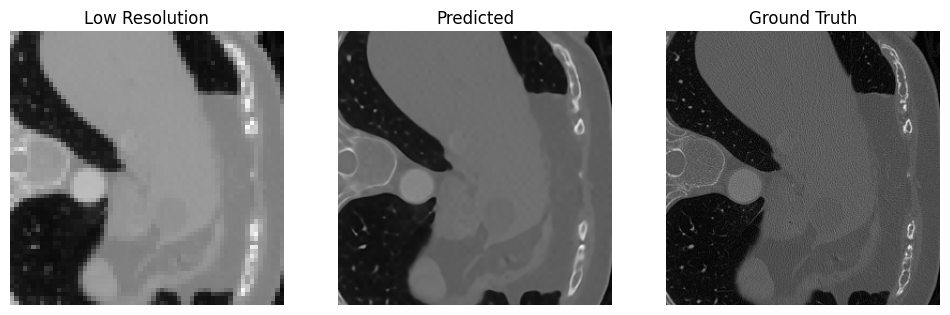

Average SSIM: 0.7245
Average PSNR: 30.1654


In [ ]:

# Entrenar el modelo
model_SRCNN=train_model(model_SRCNN, train_loader, val_loader, criterion, optimizer, epochs=50)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_and_plot_random(model_SRCNN, test_loader, device)
torch.save(model_SRCNN, 'model_SRCNN.pth')

## SIMPLE SRCNN

Epoch [1/30], Train Loss: 0.33983908112410904, Val Loss: 0.19478934461420233
Mejor modelo guardado con pérdida de validación: 0.19478934461420233
Epoch [2/30], Train Loss: 0.1968450321587607, Val Loss: 0.18090919608419592
Mejor modelo guardado con pérdida de validación: 0.18090919608419592
Epoch [3/30], Train Loss: 0.18750773816720984, Val Loss: 0.1746576674508326
Mejor modelo guardado con pérdida de validación: 0.1746576674508326
Epoch [4/30], Train Loss: 0.18365692506736356, Val Loss: 0.17544430336265854
Epoch [5/30], Train Loss: 0.18022454953263242, Val Loss: 0.1699900965798985
Mejor modelo guardado con pérdida de validación: 0.1699900965798985
Epoch [6/30], Train Loss: 0.1777338605330612, Val Loss: 0.1674301199840777
Mejor modelo guardado con pérdida de validación: 0.1674301199840777
Epoch [7/30], Train Loss: 0.17674253892573866, Val Loss: 0.1662011029142322
Mejor modelo guardado con pérdida de validación: 0.1662011029142322
Epoch [8/30], Train Loss: 0.17465361570105942, Val Loss: 

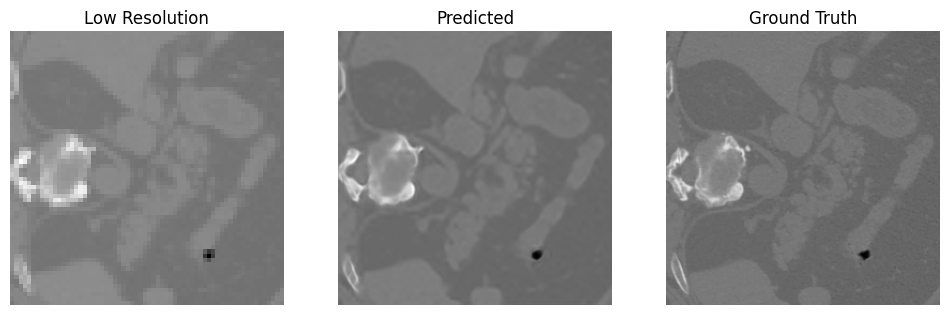

Average SSIM: 0.7276
Average PSNR: 29.9535


In [ ]:

if model_type==1 or model_type=='all':
    # Inicializar el modelo, el criterio y el optimizador
    scale_factor = 4  # O 4, dependiendo de si estás pasando de 128 a 256 o de 64 a 256
    model_SRCNN = SRCNN(scale_factor)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_SRCNN.parameters(), lr=0.001)



    # Entrenar el modelo
    model_SRCNN=train_model(model_SRCNN, train_loader, val_loader, criterion, optimizer, epochs=30)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_model_and_plot_random(model_SRCNN, test_loader, device)
    torch.save(model_SRCNN, 'model_SRCNN.pth')

## EDSR

In [ ]:
if model_type==2 or model_type=='all':
  model_EDSR = EDSRModel(num_filters=64, num_of_residual_blocks=32, scale_factor=4)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model_EDSR.parameters(), lr=0.01)

  model_EDSR=train_model(model_EDSR, train_loader, val_loader, criterion, optimizer, epochs=30)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  test_model_and_plot_random(model_EDSR, test_loader, device)
  torch.save(model_EDSR, 'model_EDSR.pth')

KeyboardInterrupt: 

## MODIFIED SRCNN

Epoch [1/30], Train Loss: 158.14094531373755, Val Loss: 0.44265232664166076
Mejor modelo guardado con pérdida de validación: 0.44265232664166076
Epoch [2/30], Train Loss: 0.9762103120408633, Val Loss: 0.28545704664606036
Mejor modelo guardado con pérdida de validación: 0.28545704664606036
Epoch [3/30], Train Loss: 0.8798358065260987, Val Loss: 0.2493725816408793
Mejor modelo guardado con pérdida de validación: 0.2493725816408793
Epoch [4/30], Train Loss: 0.2476799750722336, Val Loss: 0.227703527293422
Mejor modelo guardado con pérdida de validación: 0.227703527293422
Epoch [5/30], Train Loss: 0.23395231511110462, Val Loss: 0.21830403488693814
Mejor modelo guardado con pérdida de validación: 0.21830403488693814
Epoch [6/30], Train Loss: 0.22643077669208617, Val Loss: 0.21229317806886905
Mejor modelo guardado con pérdida de validación: 0.21229317806886905
Epoch [7/30], Train Loss: 0.22107099686615198, Val Loss: 0.20791447298093277
Mejor modelo guardado con pérdida de validación: 0.207914

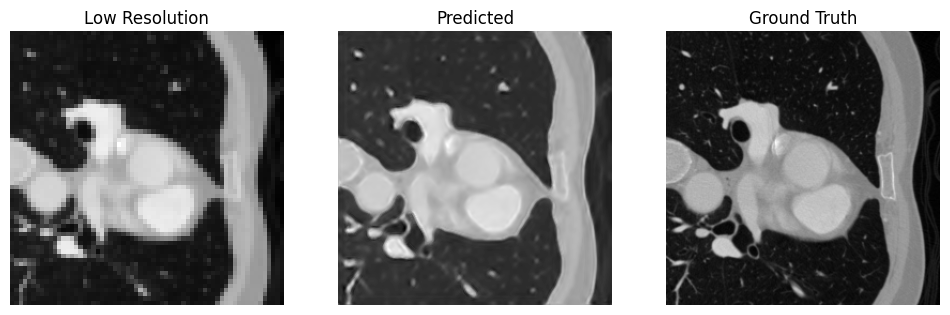

Average SSIM: 0.6919
Average PSNR: 29.0959


In [ ]:

if model_type==3 or model_type=='all':
    # Inicializar el modelo, el criterio y el optimizador
    scale_factor = 4  # O 4, dependiendo de si estás pasando de 128 a 256 o de 64 a 256
    model_modified_SRCNN = ModifiedSRCNN(scale_factor)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_modified_SRCNN.parameters(), lr=0.01)



    # Entrenar el modelo
    model_modified_SRCNN=train_model(model_modified_SRCNN, train_loader, val_loader, criterion, optimizer, epochs=30)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_model_and_plot_random(model_modified_SRCNN, test_loader, device)
    torch.save(model_modified_SRCNN, 'model_modified_SRCNN.pth')

## SRResNet

Epoch [1/30], Train Loss: 353.9374303803834, Val Loss: 0.9114320151733629
Mejor modelo guardado con pérdida de validación: 0.9114320151733629
Epoch [2/30], Train Loss: 0.8845733608253271, Val Loss: 0.8157701185255339
Mejor modelo guardado con pérdida de validación: 0.8157701185255339
Epoch [3/30], Train Loss: 0.8038090643715766, Val Loss: 0.7475389513102445
Mejor modelo guardado con pérdida de validación: 0.7475389513102445
Epoch [4/30], Train Loss: 0.7402693230354368, Val Loss: 0.6898832700469277
Mejor modelo guardado con pérdida de validación: 0.6898832700469277
Epoch [5/30], Train Loss: 0.6891579178056828, Val Loss: 0.644019421302911
Mejor modelo guardado con pérdida de validación: 0.644019421302911
Epoch [6/30], Train Loss: 0.6400764770081071, Val Loss: 0.6515731540593234
Epoch [7/30], Train Loss: 0.587023073597177, Val Loss: 0.5344070972818317
Mejor modelo guardado con pérdida de validación: 0.5344070972818317
Epoch [8/30], Train Loss: 0.5327775009875168, Val Loss: 0.4980383551481

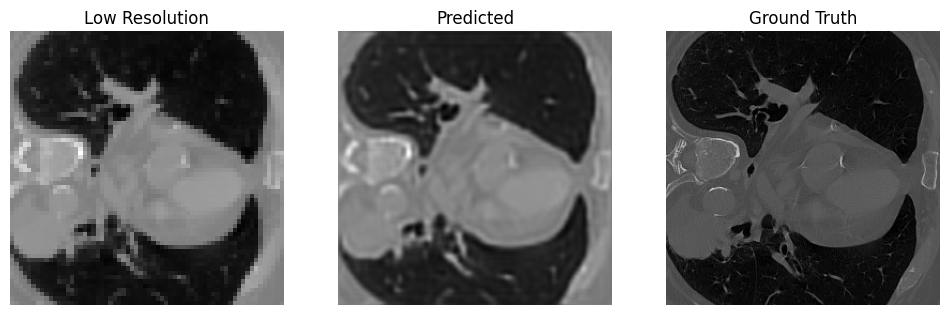

Average SSIM: 0.6279
Average PSNR: 27.4306


In [ ]:

if model_type==4 or model_type=='all':
    # Inicializar el modelo, el criterio y el optimizador
    scale_factor = 4  # O 4, dependiendo de si estás pasando de 128 a 256 o de 64 a 256
    model_SRResNet = SRResNetDense()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_SRResNet.parameters(), lr=0.01)
    # Entrenar el modelo
    model_SRResNet=train_model(model_SRResNet, train_loader, val_loader, criterion, optimizer, epochs=30)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_model_and_plot_random(model_SRResNet, test_loader, device)
    torch.save(model_SRResNet, 'model_SRResNet.pth')

Epoch [1/30], Train Loss: 0.4467092032910321, Val Loss: 0.22855149548162113
Mejor modelo guardado con pérdida de validación: 0.22855149548162113
Epoch [2/30], Train Loss: 0.22840815915903692, Val Loss: 0.20584692128679968
Mejor modelo guardado con pérdida de validación: 0.20584692128679968
Epoch [3/30], Train Loss: 0.2089702931707471, Val Loss: 0.19044767816861471
Mejor modelo guardado con pérdida de validación: 0.19044767816861471
Epoch [4/30], Train Loss: 0.19553010887556965, Val Loss: 0.1833489609487129
Mejor modelo guardado con pérdida de validación: 0.1833489609487129
Epoch [5/30], Train Loss: 0.18946404175303788, Val Loss: 0.17629888382824985
Mejor modelo guardado con pérdida de validación: 0.17629888382824985
Epoch [6/30], Train Loss: 0.1837360100813413, Val Loss: 0.17520282891663638
Mejor modelo guardado con pérdida de validación: 0.17520282891663638
Epoch [7/30], Train Loss: 0.18160375526559028, Val Loss: 0.1708464523156484
Mejor modelo guardado con pérdida de validación: 0.17

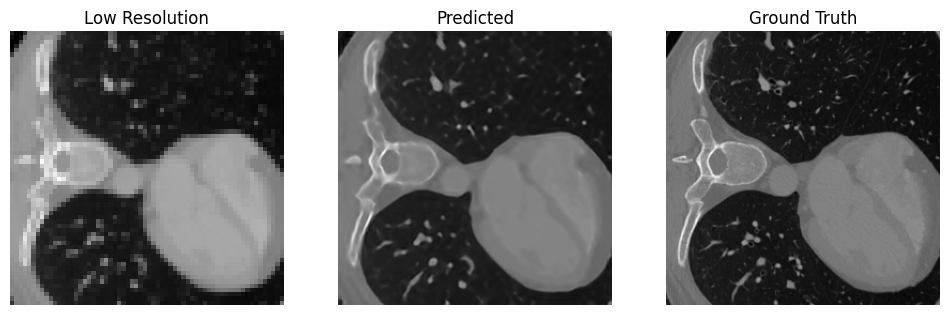

Average SSIM: 0.7226
Average PSNR: 29.9274


PicklingError: Can't pickle <class '__main__.SRCNNSE'>: it's not the same object as __main__.SRCNNSE

In [ ]:

if model_type==5 or model_type=='all':
    # Inicializar el modelo, el criterio y el optimizador
    scale_factor = 4  # O 4, dependiendo de si estás pasando de 128 a 256 o de 64 a 256
    SRCNNSE = SRCNNSE()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(SRCNNSE.parameters(), lr=0.001)
    # Entrenar el modelo
    SRCNNSE=train_model(SRCNNSE, train_loader, val_loader, criterion, optimizer, epochs=30)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
torch.save(SRCNNSE.state_dict(), 'model_SRCNNSE_state_dict.pth')


## RCAN

Epoch [1/100], Train Loss: 0.25437086497743927, Val Loss: 0.19108954676323467
Mejor modelo guardado con pérdida de validación: 0.19108954676323467
Epoch [2/100], Train Loss: 0.18146337104133434, Val Loss: 0.17267334684729577
Mejor modelo guardado con pérdida de validación: 0.17267334684729577
Epoch [3/100], Train Loss: 0.16960024633962248, Val Loss: 0.16470435774988598
Mejor modelo guardado con pérdida de validación: 0.16470435774988598
Epoch [4/100], Train Loss: 0.16343348489867315, Val Loss: 0.1602176537944211
Mejor modelo guardado con pérdida de validación: 0.1602176537944211
Epoch [5/100], Train Loss: 0.15893856602617437, Val Loss: 0.15590943271915117
Mejor modelo guardado con pérdida de validación: 0.15590943271915117
Epoch [6/100], Train Loss: 0.15571075341560775, Val Loss: 0.15325625588496525
Mejor modelo guardado con pérdida de validación: 0.15325625588496525
Epoch [7/100], Train Loss: 0.1528739521900813, Val Loss: 0.15150931254029273
Mejor modelo guardado con pérdida de valida

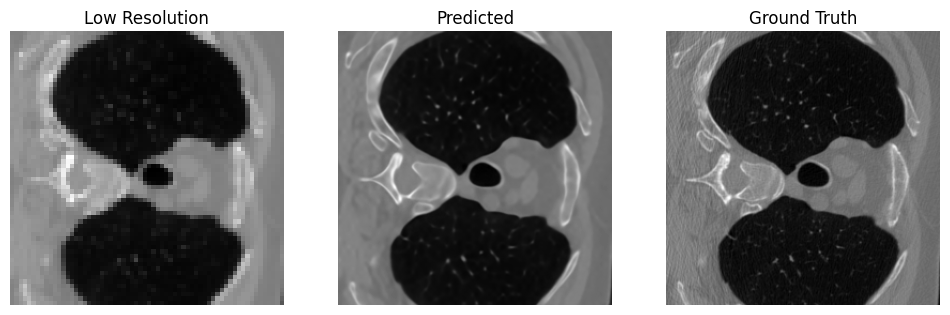

Average SSIM: 0.7458
Average PSNR: 30.8924


In [ ]:
# if model_type==6 or model_type=='all':
    # Inicializar el modelo, el criterio y el optimizador
scale_factor = 4  # O 4, dependiendo de si estás pasando de 128 a 256 o de 64 a 256
model_SRCNN = RCAN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_SRCNN.parameters(), lr=0.0001)



# Entrenar el modelo
model_SRCNN=train_model(model_SRCNN, train_loader, val_loader, criterion, optimizer, epochs=100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_and_plot_random(model_SRCNN, test_loader, device)
torch.save(model_SRCNN, 'model_SRCNN.pth')

## SWINIR

In [ ]:
upscale = 4
window_size = 8
height = (256 // upscale // window_size + 1) * window_size
width = (256 // upscale // window_size + 1) * window_size
model_SWIN = SwinIR(upscale=4, img_size=(height, width),
                window_size=window_size, img_range=1., depths=[6, 4, 4, 6],
                embed_dim=80, num_heads=[4, 8, 8, 4], mlp_ratio=4, upsampler='pixelshuffledirect')


Epoch [1/100], Train Loss: 0.30825305712512796, Val Loss: 0.22894773963424894
Mejor modelo guardado con pérdida de validación: 0.22894773963424894
Epoch [2/100], Train Loss: 0.2178089800187283, Val Loss: 0.19891649732987085
Mejor modelo guardado con pérdida de validación: 0.19891649732987085
Epoch [3/100], Train Loss: 0.18861621151574784, Val Loss: 0.17777531213230557
Mejor modelo guardado con pérdida de validación: 0.17777531213230557
Epoch [4/100], Train Loss: 0.17438253490254282, Val Loss: 0.1678252255751027
Mejor modelo guardado con pérdida de validación: 0.1678252255751027
Epoch [5/100], Train Loss: 0.16650751512497663, Val Loss: 0.16217526313331393
Mejor modelo guardado con pérdida de validación: 0.16217526313331393
Epoch [6/100], Train Loss: 0.1614723404041595, Val Loss: 0.1574932035472658
Mejor modelo guardado con pérdida de validación: 0.1574932035472658
Epoch [7/100], Train Loss: 0.15799352646701867, Val Loss: 0.15604877198735873
Mejor modelo guardado con pérdida de validació

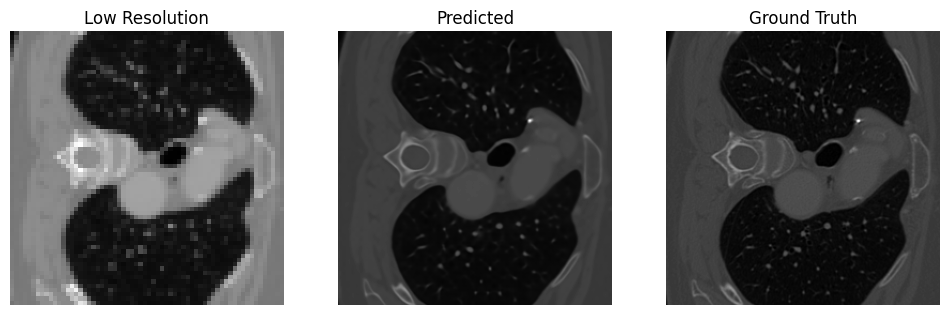

Average SSIM: 0.7557
Average PSNR: 31.3532


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_SWIN.parameters(), lr=0.0001)



# Entrenar el modelo
model_SWIN=train_model(model_SWIN, train_loader, val_loader, criterion, optimizer, epochs=100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_and_plot_random(model_SWIN, test_loader, device)
torch.save(model_SWIN, 'model_SRCNN.pth')

In [ ]:
torch.save(model_SWIN, '/content/drive/MyDrive/TFM/model_SWIN.pth')

# GANs

In [ ]:
import torch
import torch.nn as nn
def print_size_hook(module, input, output):
    print(f"{module.__class__.__name__}:")
    print(f"Entrada: {input[0].size()} | Salida: {output.size()}")
class ChannelAttention(nn.Module):
    def __init__(self, num_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(num_channels, 256, 1, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv2d(256, num_channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + residual
        return out

class ModifiedGenerator(nn.Module):
    def __init__(self, original_model):
        super(ModifiedGenerator, self).__init__()
        # Asumimos que 'original_model' es tu modelo original pre-entrenado
        self.features = original_model
        # Añadir una nueva capa convolucional
        # El número de canales de entrada y salida es 1, y el tamaño del kernel es 3
        self.extra_conv = nn.Conv2d(1, 1, kernel_size=3, padding=1)
        self.ca = ChannelAttention(1)
        self.resblock = ResidualBlock(1)
    def forward(self, x):
        x = self.features(x)
        x = self.extra_conv(x)
        x = self.ca(x) * x
        x = self.resblock(x)
        return x

# Cargar el modelo pre-entrenado
path = '/content/drive/MyDrive/TFM/model_SRCAN.pth'
original_generator = torch.load(path)
generator = ModifiedGenerator(original_generator)
# Congelar todas las capas del generador excepto la última
for param in generator.features.parameters():
    param.requires_grad = False


In [ ]:
# Mover los modelos al dispositivo
discriminator = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Definir el criterio de pérdida y los optimizadores
criterion = nn.BCEWithLogitsLoss().to(device)
content_loss_criterion = nn.MSELoss().to(device)  # Pérdida de contenido (usualmente MSE)
optimizer_g = torch.optim.Adam(generator.extra_conv.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.01)



In [ ]:
truncated_vgg19 = TruncatedVGG19(i=1 ,j=1)  # Debes definir i y j según tus necesidades

truncated_vgg19.to(device)

# Congelar los pesos del TruncatedVGG19 para que no se actualicen durante el entrenamiento
for param in truncated_vgg19.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 96.2MB/s]


In [ ]:
optimizer_g = torch.optim.Adam(generator.extra_conv.parameters(), lr=0.001)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.01)
model_EDSR_gan, discriminator = train_gan(
    generator, discriminator, truncated_vgg19, content_loss_criterion, criterion,
    train_loader, 20, optimizer_g, optimizer_d, device)



Epoch [1/20], Step [719/720], Loss D: 0.0, Loss G: 0.08947479724884033
Epoch [2/20], Step [719/720], Loss D: 259.9718017578125, Loss G: 6.510068416595459


KeyboardInterrupt: 

In [ ]:
torch.save(model_EDSR_gan.state_dict(), 'generator_model_EDSR.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


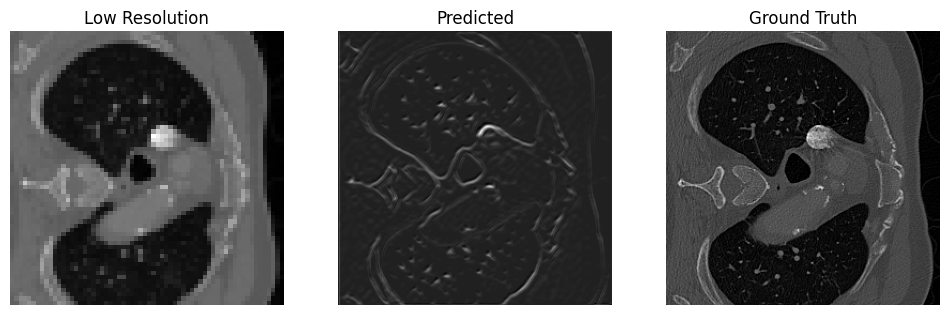

Average SSIM: 0.0981
Average PSNR: 19.2927


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model_and_plot_random(model_EDSR_gan, test_loader, device)

# INFERENCE

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=94c12f94ef0c409049081d76b5b1408da861605d4cef862df1df4e55b307024c
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
archivos_model = []
path = '/content/drive/MyDrive/TFM'  # El directorio con los archivos .npy
# Recorrer cada archivo en el directorio
for archivo in os.listdir(path):

    # Verificar si el nombre del archivo comienza con 'model'
    if archivo.startswith('model'):
        archivos_model.append(archivo)
# Mostrar la lista de archivos
print(archivos_model)

['model_modified_SRCNN.pth', 'model_EDSR.pth', 'model_SRCNN.pth', 'model_SRResNet.pth', 'model_SRCAN.pth', 'model_SwinIR.pth', 'model_SWIN.pth', 'model_MyNET.pth', 'model_mhmc_texture.pth']


# VISUALIZE


In [ ]:
models_path=[]
for model_path in archivos_model:
    if 'state' not in model_path:
        # Hacer algo con los archivos que contienen 'state'
        models_path.append(model_path)



model_modified_SRCNN - Average SSIM: 0.6740, Average PSNR: 28.6594
model_EDSR - Average SSIM: 0.7325, Average PSNR: 30.6570
model_SRCNN - Average SSIM: 0.6976, Average PSNR: 29.2100
model_SRResNet - Average SSIM: 0.5954, Average PSNR: 26.7342
model_SRCAN - Average SSIM: 0.7433, Average PSNR: 31.0374
model_SwinIR - Average SSIM: 0.7350, Average PSNR: 30.6178
model_SWIN - Average SSIM: 0.7483, Average PSNR: 31.2355
model_MyNET - Average SSIM: 0.7276, Average PSNR: 30.2331
model_mhmc_texture - Average SSIM: 0.7285, Average PSNR: 30.2848


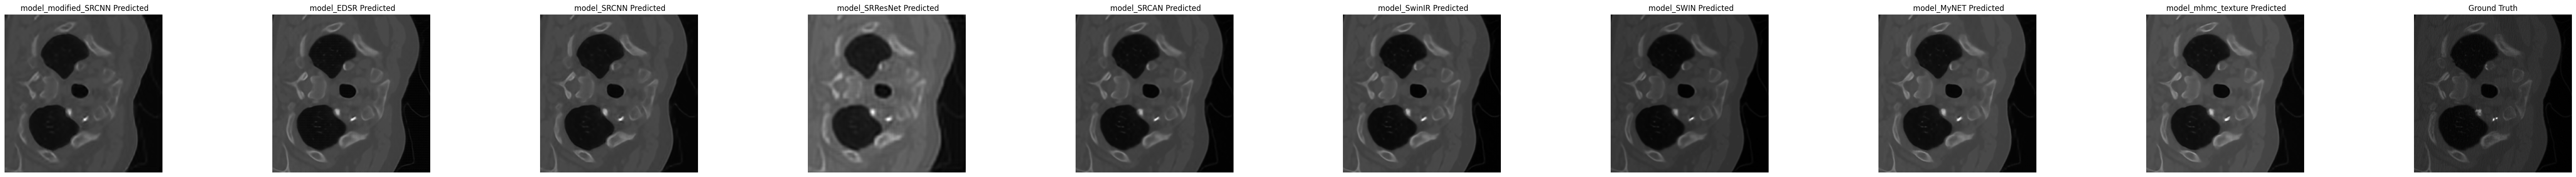

In [ ]:
import matplotlib.pyplot as plt
import torch
import random
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def test_models_and_plot(model_paths, test_loader, device):
    """
    Evalúa múltiples modelos en el conjunto de prueba, calcula las métricas SSIM y PSNR y muestra
    un plot con la imagen predicha por cada modelo y la imagen ground truth en una disposición horizontal.
    """
    num_models = len(model_paths)
    random_index = random.randint(0, len(test_loader.dataset) - 1)
    fig, axs = plt.subplots(1, num_models + 1, figsize=(6 * (num_models + 1), 4))

    for model_idx, model_path in enumerate(model_paths):
        model = torch.load(path +'/'+model_path)  # Carga el modelo
        model.to(device)
        model.eval()

        ssim_total = 0
        psnr_total = 0
        num_samples = 0
        random_image_selected = False

        with torch.no_grad():
            for i, (low_res, high_res) in enumerate(test_loader):
                low_res = low_res.to(device)
                high_res = high_res.to(device)
                outputs = model(low_res)

                for j in range(outputs.size(0)):
                    predicted = outputs[j].squeeze().cpu().numpy()
                    original = high_res[j].squeeze().cpu().numpy()

                    ssim_total += ssim(original, predicted, data_range=predicted.max() - predicted.min())
                    psnr_total += psnr(original, predicted, data_range=predicted.max() - predicted.min())

                    if i * test_loader.batch_size + j == random_index:
                        axs[model_idx].imshow(predicted, cmap='gray')
                        axs[model_idx].set_title(f" {model_path[:-4]} Predicted")
                        axs[model_idx].axis('off')

                        if model_idx == num_models - 1:
                            axs[num_models].imshow(original, cmap='gray')
                            axs[num_models].set_title("Ground Truth")
                            axs[num_models].axis('off')

                        random_image_selected = True

                num_samples += outputs.size(0)
                if random_image_selected:
                    break

        avg_ssim = ssim_total / num_samples
        avg_psnr = psnr_total / num_samples

        print(f"{model_path[:-4]} - Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.4f}")

    plt.tight_layout()
    plt.show()
# Ejemplo de uso:
# model_paths = ['path_to_model1.pth', 'path_to_model2.pth', ...]
# test_loader = DataLoader(...)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_models_and_plot(models_path, test_loader, 'cuda')


In [ ]:
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git

  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-5p6pbgdw
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-5p6pbgdw
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5acf
  Preparing metadata (setup.py) ... done
  Created wheel for RealESRGAN: filename=RealESRGAN-1.0-py3-none-any.whl size=9106 sha256=1a551f575b85a4c1f1f2a549c8bf1ac64b7b367dc6cb655b2b3452123aa50cab
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3lsbwr5/wheels/dd/a3/7d/774508ed192455403be294c8a6c4ad1c83dde8fcdd8903e64a
Successfully built RealESRGAN
